In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 7
commitnumber = 5014a19
conc = None
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 257
vmax = 1380
vmin = 1215
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

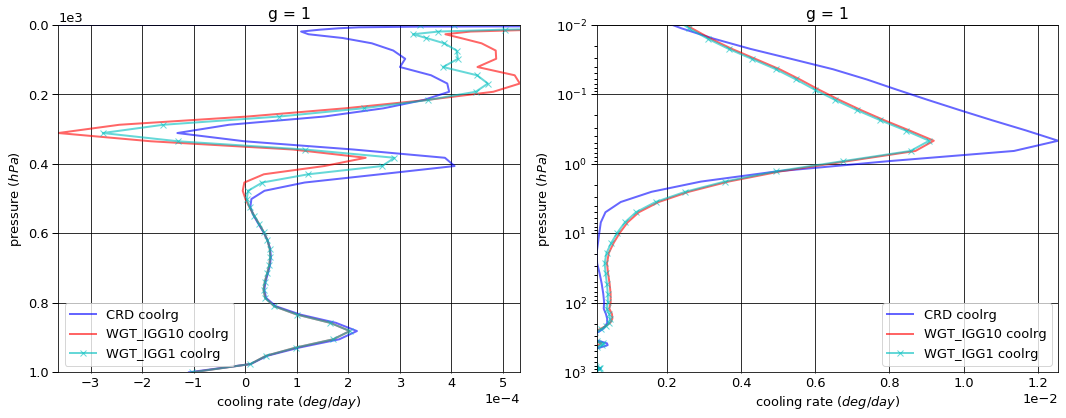

# Figure: cooling rate g-group 2

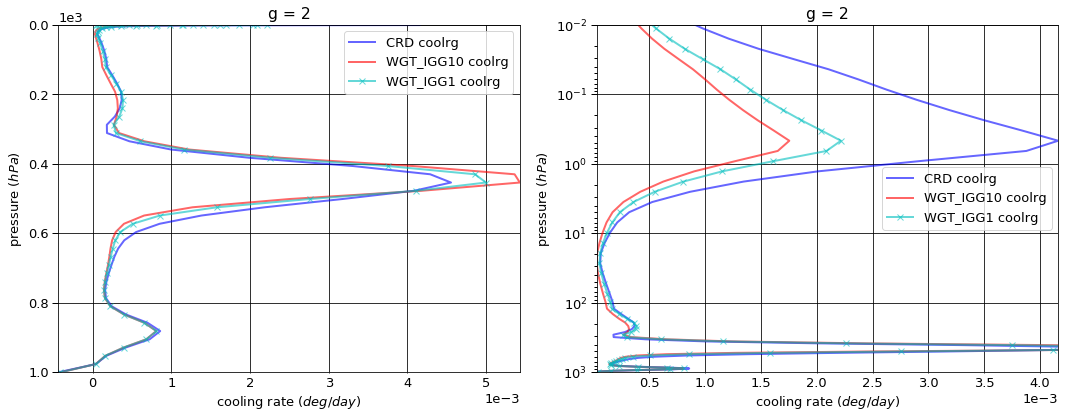

# Figure: cooling rate g-group 3

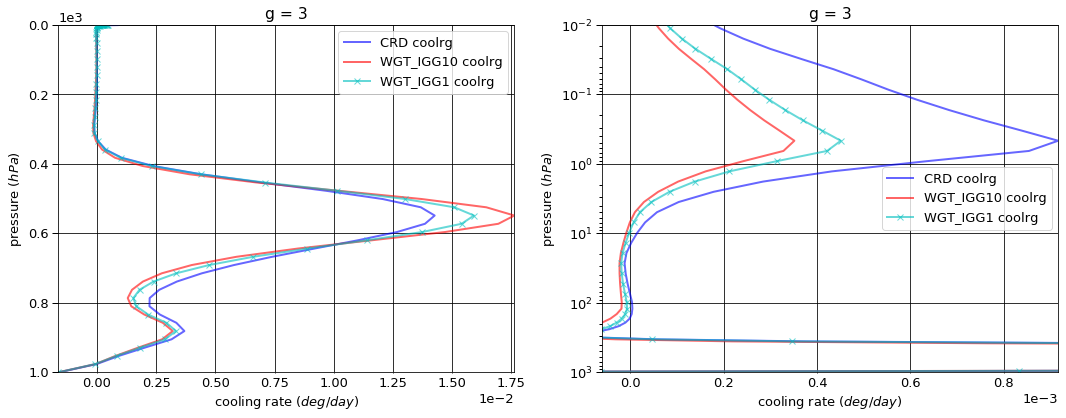

# Figure: cooling rate g-group 4

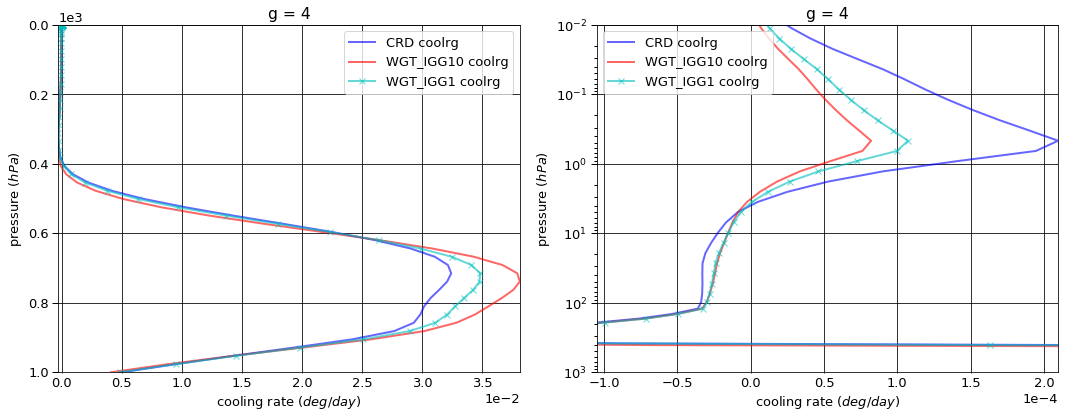

# Figure: cooling rate g-group 5

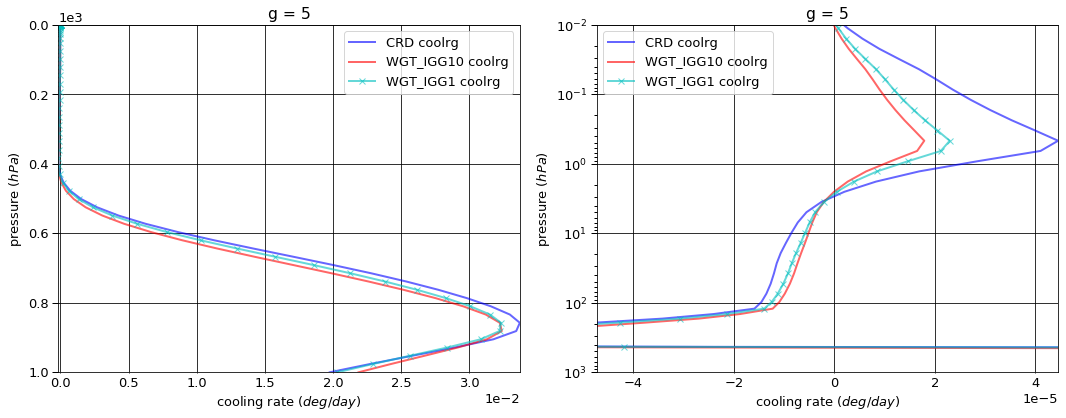

# Figure: cooling rate g-group 6

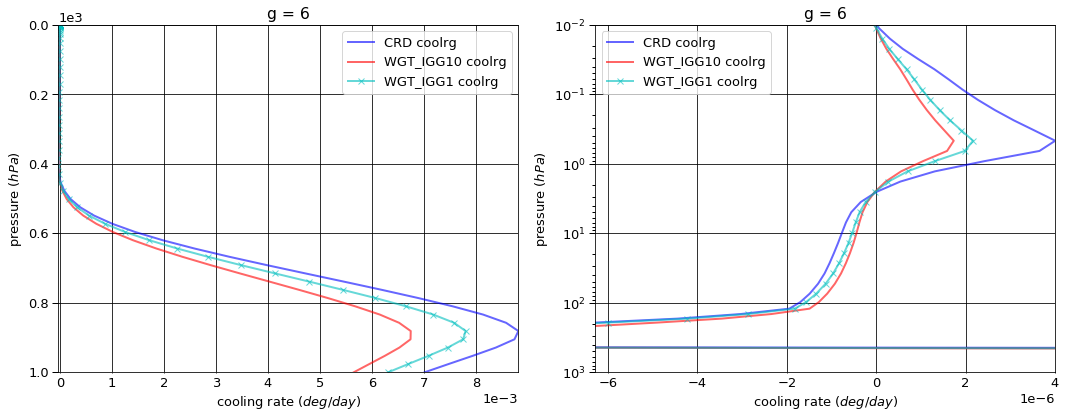

# Figure: cooling rate g-group 7

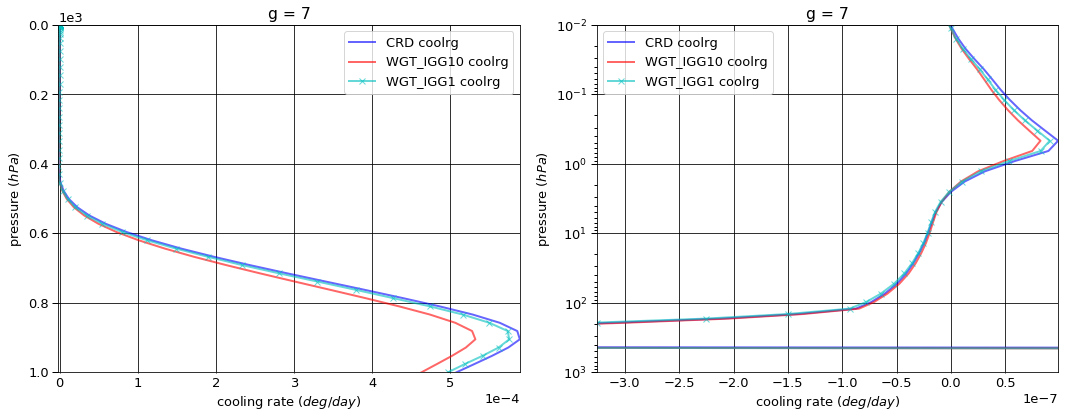

# Figure: cooling rate g-group total

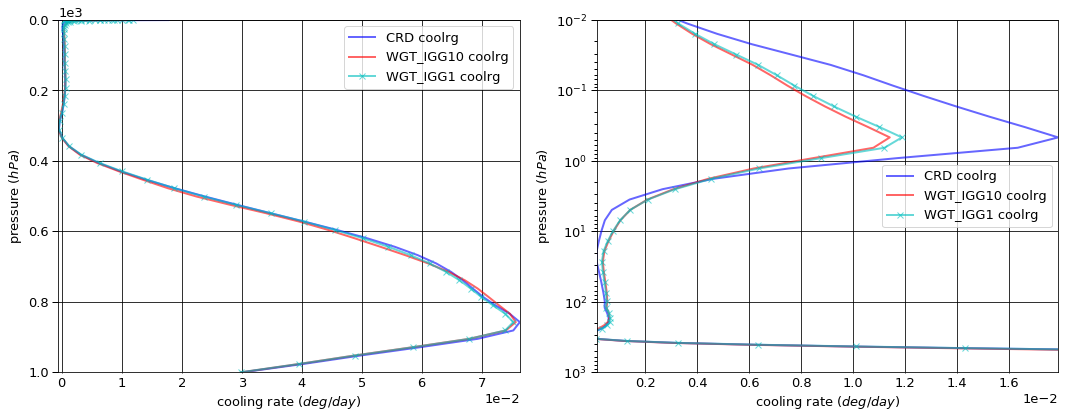

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.017546  0.000000 -0.017546
  1013.0   76    -0.064743  0.065433  0.000690
2 0.0      1     -0.099401  0.000000 -0.099401
  1013.0   76    -0.257375  0.260124  0.002749
3 0.0      1     -0.420948  0.000000 -0.420948
  1013.0   76    -0.709774  0.721524  0.011750
4 0.0      1     -1.549911  0.000000 -1.549911
  1013.0   76    -1.861798  1.754760 -0.107038
5 0.0      1     -2.711379  0.000000 -2.711379
  1013.0   76    -2.819904  1.381189 -1.438716
6 0.0      1     -2.913943  0.000000 -2.913943
  1013.0   76    -2.928949  0.328568 -2.600381
7 0.0      1     -0.914704  0.000000 -0.914704
  1013.0   76    -0.915487  0.021370 -0.894117


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.017209  0.000000 -0.017209
  1013.0   76    -0.064040  0.064687  0.000647
2 0.0      1     -0.098042  0.000000 -0.098042
  1013.0   76    -0.255316  0.257898  0.002582
3 0.0      1     -0.420164  0.000000 -0.420164
  1013.0   76    -0.705310  0.715660  0.010349
4 0.0      1     -1.565323  0.000000 -1.565323
  1013.0   76    -1.851444  1.838566 -0.012878
5 0.0      1     -2.737148  0.000000 -2.737148
  1013.0   76    -2.816585  1.268063 -1.548522
6 0.0      1     -2.931148  0.000000 -2.931148
  1013.0   76    -2.941778  0.248458 -2.693320
7 0.0      1     -0.922849  0.000000 -0.922849
  1013.0   76    -0.923558  0.019109 -0.904449


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.017436  0.000000 -0.017436
  1013.0   76    -0.064040  0.064687  0.000647
2 0.0      1     -0.098232  0.000000 -0.098232
  1013.0   76    -0.255316  0.257904  0.002589
3 0.0      1     -0.419069  0.000000 -0.419069
  1013.0   76    -0.705310  0.716146  0.010836
4 0.0      1     -1.552990  0.000000 -1.552990
  1013.0   76    -1.851444  1.801445 -0.049999
5 0.0      1     -2.720552  0.000000 -2.720552
  1013.0   76    -2.816585  1.312168 -1.504417
6 0.0      1     -2.928322  0.000000 -2.928322
  1013.0   76    -2.941778  0.290446 -2.651331
7 0.0      1     -0.922766  0.000000 -0.922766
  1013.0   76    -0.923558  0.020791 -0.902767


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000337  0.000000  0.000337
  1013.0   76     0.000703 -0.000745 -0.000042
2 0.0      1      0.001359  0.000000  0.001359
  1013.0   76     0.002059 -0.002226 -0.000167
3 0.0      1      0.000784  0.000000  0.000784
  1013.0   76     0.004464 -0.005864 -0.001401
4 0.0      1     -0.015412  0.000000 -0.015412
  1013.0   76     0.010354  0.083806  0.094160
5 0.0      1     -0.025769  0.000000 -0.025769
  1013.0   76     0.003320 -0.113126 -0.109807
6 0.0      1     -0.017204  0.000000 -0.017204
  1013.0   76    -0.012829 -0.080110 -0.092938
7 0.0      1     -0.008145  0.000000 -0.008145
  1013.0   76    -0.008070 -0.002261 -0.010332


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000111  0.000000  0.000111
  1013.0   76     0.000703 -0.000745 -0.000042
2 0.0      1      0.001169  0.000000  0.001169
  1013.0   76     0.002059 -0.002220 -0.000160
3 0.0      1      0.001879  0.000000  0.001879
  1013.0   76     0.004464 -0.005377 -0.000914
4 0.0      1     -0.003078  0.000000 -0.003078
  1013.0   76     0.010354  0.046685  0.057039
5 0.0      1     -0.009173  0.000000 -0.009173
  1013.0   76     0.003320 -0.069021 -0.065701
6 0.0      1     -0.014379  0.000000 -0.014379
  1013.0   76    -0.012829 -0.038122 -0.050950
7 0.0      1     -0.008062  0.000000 -0.008062
  1013.0   76    -0.008070 -0.000579 -0.008649

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.215061e-03
  1001.112500 75    -1.091359e-04
2 0.000312    1      2.552415e-06
  1001.112500 75    -4.356276e-04
3 0.000312    1     -7.247111e-06
  1001.112500 75    -1.597277e-03
4 0.000312    1     -2.945247e-05
  1001.112500 75     4.993932e-03
5 0.000312    1     -9.343711e-06
  1001.112500 75     1.975116e-02
6 0.000312    1     -7.315306e-07
  1001.112500 75     7.014687e-03
7 0.000312    1     -1.684444e-08
  1001.112500 75     5.081613e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      3.811853e-04
  1001.112500 75    -1.021989e-04
2 0.000312    1      1.613669e-05
  1001.112500 75    -4.077395e-04
3 0.000312    1     -1.779819e-05
  1001.112500 75    -1.627855e-03
4 0.000312    1     -1.659815e-05
  1001.112500 75     4.077620e-03
5 0.000312    1     -4.783687e-06
  1001.112500 75     2.186299e-02
6 0.000312    1     -3.489689e-07
  1001.112500 75     5.652253e-03
7 0.000312    1     -1.494565e-08
  1001.112500 75     4.633654e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      3.396008e-04
  1001.112500 75    -1.021989e-04
2 0.000312    1      3.741942e-05
  1001.112500 75    -4.089854e-04
3 0.000312    1     -1.585475e-05
  1001.112500 75    -1.622700e-03
4 0.000312    1     -1.748999e-05
  1001.112500 75     4.836123e-03
5 0.000312    1     -5.541930e-06
  1001.112500 75     2.030669e-02
6 0.000312    1     -4.278805e-07
  1001.112500 75     6.313575e-03
7 0.000312    1     -1.649320e-08
  1001.112500 75     4.972431e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.596246e-03
  1001.112500 75     6.937080e-06
2 0.000312    1      1.358427e-05
  1001.112500 75     2.788814e-05
3 0.000312    1     -1.055108e-05
  1001.112500 75    -3.057740e-05
4 0.000312    1      1.285432e-05
  1001.112500 75    -9.163126e-04
5 0.000312    1      4.560023e-06
  1001.112500 75     2.111829e-03
6 0.000312    1      3.825617e-07
  1001.112500 75    -1.362434e-03
7 0.000312    1      1.898789e-09
  1001.112500 75    -4.479593e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.554662e-03
  1001.112500 75     6.937080e-06
2 0.000312    1      3.486701e-05
  1001.112500 75     2.664222e-05
3 0.000312    1     -8.607640e-06
  1001.112500 75    -2.542210e-05
4 0.000312    1      1.196248e-05
  1001.112500 75    -1.578090e-04
5 0.000312    1      3.801781e-06
  1001.112500 75     5.555250e-04
6 0.000312    1      3.036501e-07
  1001.112500 75    -7.011119e-04
7 0.000312    1      3.512390e-10
  1001.112500 75    -1.091827e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.627833,0.000000,-8.627833
1013.0,76,-9.558030,4.532967,-5.025063



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.691884,0.000000,-8.691884
1013.0,76,-9.558030,4.412439,-5.145591



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.659366,0.000000,-8.659366
1013.0,76,-9.558030,4.463588,-5.094442



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.405076e-02,0.000000,-0.064051
1013.0,76,-3.700000e-08,-0.120528,-0.120528



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.153299e-02,0.000000,-0.031533
1013.0,76,-3.700000e-08,-0.069379,-0.069379


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.001259
1001.112500,75,0.030126



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000358
1001.112500,75,0.029918



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000338
1001.112500,75,0.029820



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001617
1001.112500,75,-0.000207



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001597
1001.112500,75,-0.000306


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008442,0.006700
2,0.031667,0.026712
3,0.084558,0.073792
4,0.218406,0.193706
5,0.300933,0.294683
6,0.277224,0.307781
7,0.078770,0.096626


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.695655e-20
2,2.527212e-21
3,3.766568e-22
4,5.613710e-23
5,8.366699e-24
6,1.246977e-24
7,1.858499e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.695655e-20,NaN,0.008442,0.006700,0.008442,0.006700,600.0
2,2.527212e-21,0.14904,0.031667,0.026712,0.040109,0.033412,600.0
3,3.766568e-22,0.14904,0.084558,0.073792,0.124667,0.107205,600.0
4,5.613710e-23,0.14904,0.218406,0.193706,0.343073,0.300910,600.0
5,8.366699e-24,0.14904,0.300933,0.294683,0.644006,0.595593,600.0
6,1.246977e-24,0.14904,0.277224,0.307781,0.921230,0.903374,600.0
7,1.858499e-25,0.14904,0.078770,0.096626,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
